## 通し課題　課題①Kickstarter Projects

### DAY2受講後の目標
- 正規化等の前処理を行ったうえで、SVMを実装してみる。

#### 【メモ】Slackより
- なるべくfor ループを使わずに、pandasの関数で完結させるのが良い。forループを使うと計算が遅くなる
- pd.to_datetime()を使うと、timedate型に1発で変換できる
- csvデータを読み込むときは、まずは、対象の列を指定せずに、全て読み込んで、どんなデータが入っているのかを確認しよう
- 散布図を描くとき、データが重なって見にくい場合は、markerを小さくし、半透明にすると、見やすくなる
- dropnaを行うときは、タイミングが大事。早い段階でdropnaすると、使えるデータを落としてしまうことになる
- pd.get_dummies()を実行するときは、対象とする列を選択すること。不要な列を含めてしまうと、計算が重くなり、パソコンが固まってしまう
- カテゴリデータを数字化するとき、labelEncoderを使うと、連続的な数字になってしまい、数字の大小に意味が発生してしまうことに注意

In [1]:
%matplotlib inline
#import os
#import codecs
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() 
import category_encoders as ce  # カテゴリーエンコーダを使ってみる
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

### １ Read csv data

In [2]:
# ks-projects-201801.csv の読み込み
df_ks = pd.read_csv("data/01 Kickstarter Projects/ks-projects-201801.csv")

In [3]:
print(df_ks.columns)

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')


In [4]:
# とりあえずデータを表示
df_ks.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [5]:
#欠損値の確認
print(df_ks.index)

df_ks.isnull().sum()

RangeIndex(start=0, stop=378661, step=1)


ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

###### 　データ数：378660個
- nemeは加工することで有用なデータになる　⇒　中條氏の課題を参考に
- usd_pledgedの欠損値は、使わないデータなので無視してOK
- usd_goal_real は使える情報
- backers は支援者数なので説明変数に加えてはいけない（先生コメ）

##### メモ　currency：通貨　goal系：目標額　pledged系：融資（申出）出額　backers：支援者数
##### 　●成否判定は pledged が goal を超えたかどうかで判断できる（※福本さんはこれを使って回帰問題で解いていた）
##### 　●説明変数として pledged, backers は使えない（目的変数とほぼほぼイコールであるため）

In [6]:
#とりあえず”state”が”failed”か”successful”のデータを抽出する

df_ks = df_ks[(df_ks['state'] == 'failed')|(df_ks['state'] =='successful')]
df_ks.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,successful,224,US,52375.0,52375.0,50000.00


### 　２．前処理＆グラフ描画
- 他の方のアプローチを参考に使えるデータを見ていく
- 使えない（使ってはいけない）もの・・・ID, pledged系（獲得資金）, backer（支援者）
- nameやcategoryは使えるように変換する必要がある？

In [7]:
# 使わないデータをテーブルから削除
df1 = df_ks.drop(['ID', 'pledged', 'backers', 'usd pledged', 'usd_pledged_real'] , axis=1)
df1.head()

,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed,GB,1533.95
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed,US,30000.00
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed,US,45000.00
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,failed,US,5000.00
5,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,successful,US,50000.00


In [8]:
# state の文字データを０，１へ変換（DAY1_進捗シートコメントを参考） 
df1['state']= (df1['state'] == 'successful')
df1.head()

df_temp = df1

In [9]:
# 全体の成功率
print(df1['state'].sum())
print(df1['state'].sum()/331675*100)

133956
40.38772895153388


- 抽出後のデータ数は331675／378860
- さらに 133956／331675 ≒ 40.4% が成功している

- ここまでを基本的な読み込み操作とする
- 以降の操作は、df1をベースとして、テンポラリーデータフレームで実行する（途中のやり直しがしやすいように）

In [10]:
# deadline と launched から募集期間（term）を求める（DAY1_進捗シートコメントを参考）
df_term = pd.to_datetime(df_temp['deadline'])-pd.to_datetime(df_temp['launched'])
df_temp['term'] = df_term.dt.days
df_temp.head()

,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,term
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,False,GB,1533.95,58
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,False,US,30000.00,59
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,False,US,45000.00,44
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,False,US,5000.00,29
5,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,True,US,50000.00,34


In [11]:
df_temp.describe()

,goal,usd_goal_real,term
count,3.316750e+05,3.316750e+05,331675.000000
mean,4.425157e+04,4.151000e+04,32.954902
std,1.117917e+06,1.108930e+06,12.713329
min,1.000000e-02,1.000000e-02,0.000000
25%,2.000000e+03,2.000000e+03,29.000000
50%,5.000000e+03,5.000000e+03,29.000000
75%,1.500000e+04,1.500000e+04,35.000000
max,1.000000e+08,1.663614e+08,91.000000


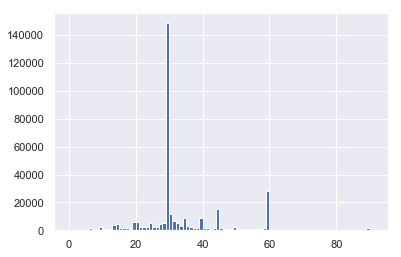

In [12]:
# 募集期間の分布　（ヒストグラムで出してみる）
df_temp['term'].hist(bins=91)   # MAX=91

In [13]:
print(df_temp['term'].mode())  #最頻値
print(df_temp['term'].value_counts().iat[0]) #最頻値の個数

0    29
dtype: int64
148478


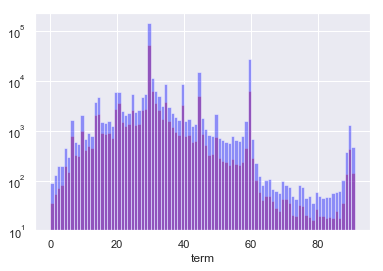

In [14]:
sns.distplot(df_temp['term'][df_temp['state'] ==1], kde=False, rug=False, color='red', bins=91)
sns.distplot(df_temp['term'], kde=False, rug=False, color='blue', bins=91)

plt.xlabel('term')
plt.yscale('log')  # 最大値が大きいのでlogスケール化
plt.show()

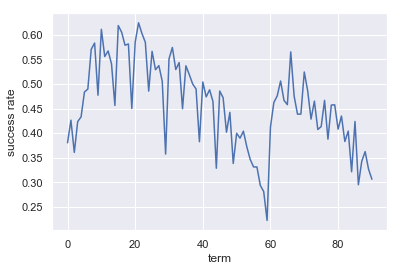

In [15]:
ret1 = plt.hist(df_temp['term'], color='blue', alpha=0.5, bins=91)
ret2 = plt.hist(df_temp['term'][df_temp['state']==1], color='red', alpha=0.5, bins=91)

plt.gca().clear()

ret3 = ret2[0]/ret1[0]
s = pd.Series(ret3)
plt.plot(s)

plt.xlabel('term')
plt.ylabel('success rate')

plt.show()

- 最も多いのは30日　時点で60日
- 募集期間における成功率の分布には２つの山がある。谷底は60日の部分
- なぜ60日で成功率が悪くなるのか？ ⇒　60日を超えるとデータ数が大きく減っているのも影響している？

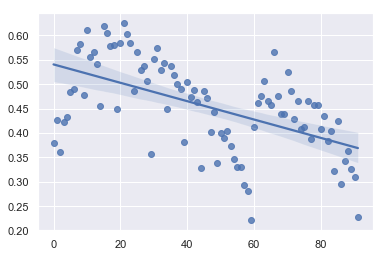

In [16]:
# 別の可視化方法：山崎氏のDAY1_notebookを参考に①
z = df_temp.groupby("term").state.mean()
sns.regplot(z.index.array, z.values)

In [17]:
df_temp[df_temp['term']==60] # 60日の行をみてみる

,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,term
120,"Jane Brown... a story of courage, survival and...",Periodicals,Publishing,USD,2011-12-31,25000.0,2011-10-31 23:01:57,False,US,25000.0,60
276,Open A.I.R.,Art,Art,USD,2010-07-12,3000.0,2010-05-12 21:45:14,True,US,3000.0,60
1171,"Kevin Dillard solo cd ""Symptoms of The Human C...",World Music,Music,USD,2011-04-04,5500.0,2011-02-02 13:27:50,False,US,5500.0,60
3067,"Surrealist Film ""The Dawn Before the Rest of t...",Film & Video,Film & Video,USD,2011-05-07,35000.0,2011-03-07 08:56:20,False,US,35000.0,60
3549,Belladonna Springs,Film & Video,Film & Video,USD,2011-04-22,30000.0,2011-02-20 19:35:31,False,US,30000.0,60
3776,OF THIEVES AND ELVES (a fantasy novella by A.P...,Publishing,Publishing,USD,2012-01-05,1500.0,2011-11-05 23:57:58,True,US,1500.0,60
4541,Mac'n Vegetarian Soul Food Truck,Food,Food,USD,2011-04-30,3000.0,2011-02-28 19:56:55,False,US,3000.0,60
4659,TRADITION TOUR 2011,Illustration,Art,USD,2011-04-21,900.0,2011-02-19 09:14:21,True,US,900.0,60
4664,Eat the Pretty Ones,Documentary,Film & Video,USD,2011-05-28,10000.0,2011-03-28 21:48:43,False,US,10000.0,60
5930,"""Short Trackin': The Roots of Racing"" A Docume...",Documentary,Film & Video,USD,2011-04-13,30000.0,2011-02-11 03:06:52,False,US,30000.0,60


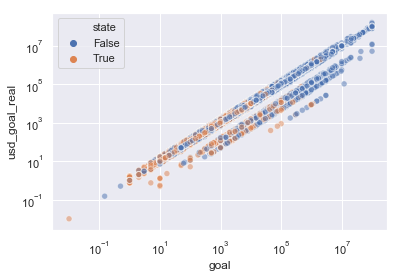

In [18]:
# goal, usd_goal_real を散布図で確認
sns.scatterplot(x='goal', y='usd_goal_real', data=df_temp, color='red', alpha=0.5, hue='state')

plt.yscale('log')  
plt.xscale('log')  

plt.xlabel('goal')
plt.ylabel('usd_goal_real')

plt.show()

- 為替レートの関係で傾きが変わっていると思われるが、おおよそ比例関係にある？

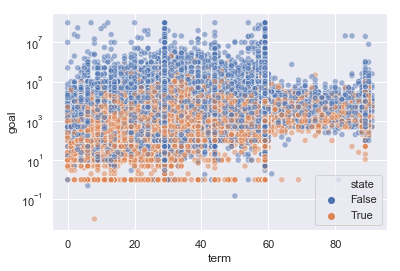

In [20]:
# 募集期間と目標額における成否分布
sns.scatterplot(x='term', y='goal', data=df_temp, color='red', alpha=0.5, hue='state')

plt.yscale('log')  # goalの最大値が大きいのでlogスケール化
plt.show()

In [21]:
# 上記２変数をロジスティック回帰にかけてみる
y = df_temp["state"].values
X = df_temp[["term", "goal"]].values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}".format(w0, w1, w2))

w0 = 9415.592, w1 = 247013.421, w2 = -367.702


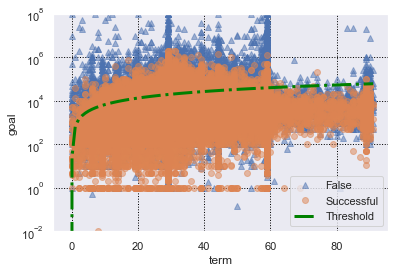

In [22]:
x1, x2 = df_temp["term"].values, df_temp["goal"].values 

# データをプロット
plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')

plt.plot(x1[~y], x2[~y], '^', color='C0', label='False', alpha=0.5)
plt.plot(x1[y], x2[y], 'o', color='C1', label='Successful', alpha=0.5)

# 境界線をプロットして表示
# 紫：境界線
line_x = np.arange(np.min(x1) - 1, np.max(x1) + 1)
line_y = - line_x * w1 / w2 - w0 / w2
plt.plot(line_x, line_y, linestyle='-.', linewidth=3, color='green', label='Threshold')
#plt.ylim([np.min(x2) - 1, np.max(x2) + 1])
plt.ylim([np.min(x2), np.max(x2)])
plt.legend(loc='best')

plt.xlabel("term")
plt.ylabel("goal")
plt.yscale('log')
plt.show()

In [23]:
# ラベルを予測
y_pred = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_pred)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_pred)))

対数尤度 = -16.874
正答率 = 51.146%


- 同じ募集期間であれば目標額は低いほうが成功しやすいようである
- 傾向としては説明できそうだが、領域が重なっているので、これらの情報だけで判断するのは難しそう ⇒　ロジスティック回帰で確認

In [24]:
df_temp[df_temp['goal']==df_temp['goal'].min()]  # goal最小値（１セント？）のデータ確認(気になった)

,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,term
304489,LOVELAND Round 6: A Force More Powerful,Conceptual Art,Art,USD,2009-12-04,0.01,2009-11-25 07:54:49,True,US,0.01,8


In [25]:
df_temp[df_temp['goal']==1]  # goal=1のデータ確認(気になった２)

,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,term
363,Wholesters- A new way to Whold your things!,Fashion,Fashion,USD,2011-05-29,1.0,2011-04-29 01:03:16,True,US,1.00,29
532,3mm Aluminum Pick Plectrum,Music,Music,CAD,2014-03-24,1.0,2014-02-22 23:28:33,True,CA,0.91,29
993,Tons Of Music For A Buck!!!,Rock,Music,USD,2015-08-15,1.0,2015-07-16 23:41:20,True,US,1.00,29
1865,Tale Of Tails,Publishing,Publishing,USD,2015-05-02,1.0,2015-04-02 18:40:40,False,US,1.00,29
1959,Kenophania: How A Song Is Created (Interactive...,Audio,Journalism,GBP,2017-11-19,1.0,2017-11-01 20:03:10,True,GB,1.33,17
3381,The Forest or: How I Learned to Love the Pine ...,Film & Video,Film & Video,USD,2015-04-26,1.0,2015-04-20 17:03:18,True,US,1.00,5
4818,The $1 Play What You Want Mystery Campaign RPG...,Games,Games,USD,2015-12-17,1.0,2015-11-17 20:32:29,True,US,1.00,29
5651,Crap Drawings,Illustration,Art,GBP,2012-12-16,1.0,2012-11-16 18:55:52,True,GB,1.62,29
5852,Sounds of New York,Music,Music,USD,2015-10-27,1.0,2015-10-20 23:22:33,True,US,1.00,6
6088,Hollywood... Here I GO!!!,Pop,Music,USD,2017-07-20,1.0,2017-06-29 17:01:15,True,US,1.00,20


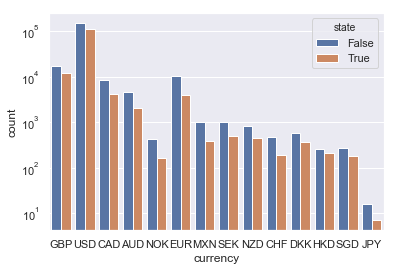

In [26]:
# currency について
sns.countplot(x='currency', data = df_temp, hue='state');
plt.yscale('log')


- ほとんどの通貨で成功率４割前後であるが、JPY（円）の成功率が悪い？

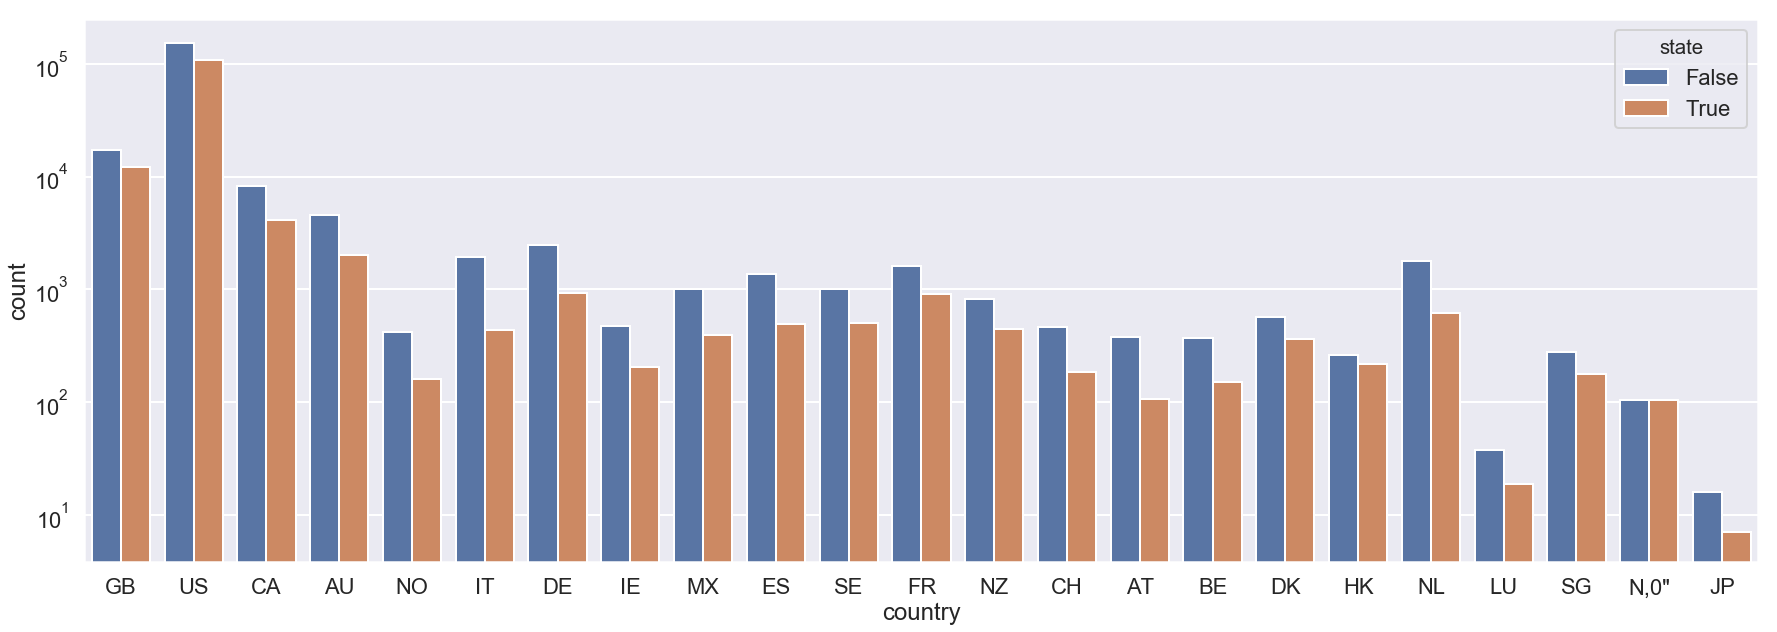

In [27]:
# country について
plt.figure(figsize=(30, 10))
sns.set_context('poster')  #フォントサイズを調整
plt.yscale('log')
sns.countplot(x='country', data = df_temp, hue='state');

sns.set_context('notebook')  #フォントサイズを元に戻す

- だいたい通貨と同じ感じ

#### currency, country をどうやって使うか？　 ⇒　それぞれの成功率を算出して使ってみる
#### 上記は Target Encording というやり方に相当する模様
#### 参考：https://www.takapy.work/entry/2019/12/10/085810　https://qiita.com/daikiclimate/items/dd5606ede544e53db5a7　など

- （メモ）Target Encording は性質上、容易に目的変数を推定できてしまうため、データ漏洩の危険性があることから、実務上は別の手法を使う必要がある場合が多いとのこと。

In [28]:
# Category Encorders ライブラリを使って実装してみる
df_cur = df_temp.loc[:,['currency', 'state']]

TE = ce.TargetEncoder()
df_cur["te_currency"] = TE.fit_transform(df_cur["currency"],df_cur["state"])

display(df_cur.head())
df_cur.describe()

,currency,state,te_currency
0,GBP,False,0.409859
1,USD,False,0.418258
2,USD,False,0.418258
3,USD,False,0.418258
5,USD,True,0.418258


,te_currency
count,331675.000000
mean,0.403877
std,0.038454
min,0.269996
25%,0.418258
50%,0.418258
75%,0.418258
max,0.452830


In [29]:
# Category Encorders ライブラリを使って実装してみる２
df_cou = df_temp.loc[:,['country', 'state']]

TE = ce.TargetEncoder()
df_cou["te_country"] = TE.fit_transform(df_cou["country"],df_cou["state"])

display(df_cou.head())
df_cou.describe()

,country,state,te_country
0,GB,False,0.409690
1,US,False,0.418193
2,US,False,0.418193
3,US,False,0.418193
5,US,True,0.418193


,te_country
count,331675.000000
mean,0.403877
std,0.040034
min,0.185310
25%,0.418193
50%,0.418193
75%,0.418193
max,0.500000


#### 続いて大分類（main_category）, 小分類（category） をどのように使うか？
#### ⇒　まずは大分類、小分類の項目、データ数をチェック

In [30]:
# main_category を変換 
df_ma = pd.get_dummies(df_temp['main_category'])
df_ma.sum()

Art             25641
Comics           9878
Crafts           7818
Dance            3573
Design          25364
Fashion         19775
Film & Video    56527
Food            22054
Games           28521
Journalism       4149
Music           45949
Photography      9689
Publishing      35445
Technology      27050
Theater         10242
dtype: int64

In [31]:
# category を変換 
df_ca = pd.get_dummies(df_temp['category'])
df_ca.sum()

3D Printing            568
Academic               777
Accessories           2740
Action                 621
Animals                229
Animation             2213
Anthologies            737
Apparel               6166
Apps                  5287
Architecture           642
Art                   7486
Art Books             2469
Audio                  363
Bacon                  181
Blues                  234
Calendars              290
Camera Equipment       350
Candles                378
Ceramics               275
Children's Books      6198
Childrenswear          418
Chiptune                33
Civic Design           266
Classical Music       2440
Comedy                2068
Comic Books           2493
Comics                4581
Community Gardens      271
Conceptual Art         930
Cookbooks              455
                     ...  
Shorts               11394
Small Batch           1621
Software              2573
Sound                  551
Space Exploration      283
Spaces                 755
S

- main_category の方が大分類になっている
- category の中には絶対数の少ない項目もある　⇒　項目ごとの成功率を見たら説明変数側の偏りが影響しそう？
- main_category と category の合わせ技が見つかればよさそうだが・・・・

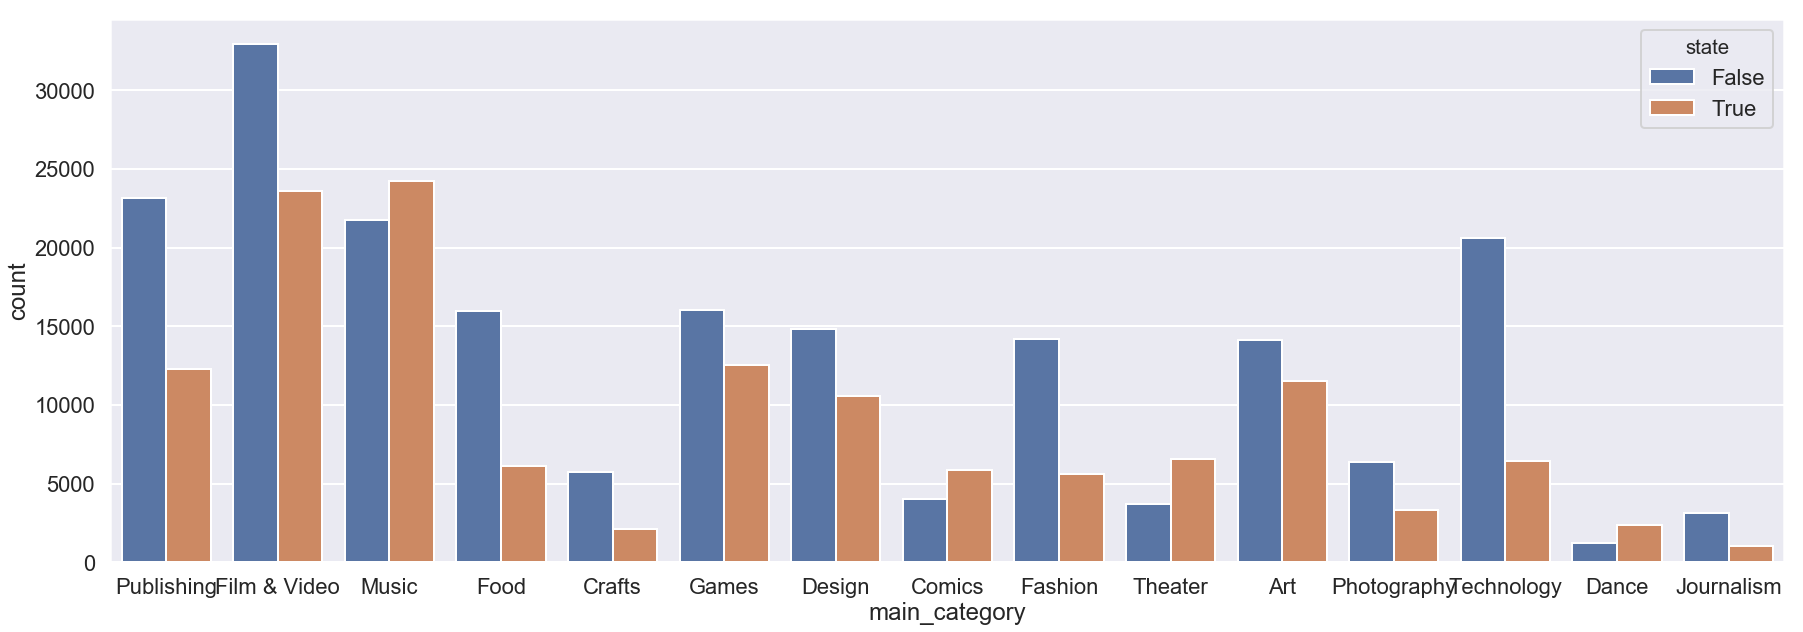

In [32]:
# main_category について
plt.figure(figsize=(30, 10))
sns.set_context('poster')  #フォントサイズを調整

sns.countplot(x='main_category', data = df_temp, hue='state');

sns.set_context('notebook')  #フォントサイズを元に戻す

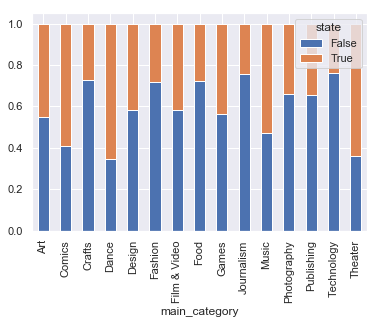

In [33]:
# 100%積み上げ棒グラフで描画してみる
mc = pd.crosstab(df_temp['main_category'], df_temp['state'], normalize='index')
# stacked=Trueで積み上げ機能オン
mc.plot.bar(stacked=True)

- 大分類によって成功率が異なるようだ
- ここでも Target Encording を適用してみる

In [34]:
# Category Encorders ライブラリを使って実装してみる３
df_MC = df_temp.loc[:,['main_category', 'state']]

TE = ce.TargetEncoder()
df_MC["te_MC"] = TE.fit_transform(df_MC["main_category"],df_MC["state"])

display(df_MC.head())
df_MC.describe()

,main_category,state,te_MC
0,Publishing,False,0.347017
1,Film & Video,False,0.417906
2,Film & Video,False,0.417906
3,Music,False,0.526606
5,Food,True,0.275914


,te_MC
count,331675.000000
mean,0.403877
std,0.105920
min,0.237856
25%,0.341108
50%,0.417906
75%,0.448890
max,0.654352


- 次に category の方は数が多いので、まずはOne-Hotベクトル化したものを使うことにする。

In [35]:
# One-Hotベクトル化（Category Encorderを使う）
df_CA = df_temp.loc[:,['category', 'state']]

ohe = ce.OneHotEncoder(['category'],handle_unknown='impute') #imputeを指定すると明示的にfitdataに含まれない要素が入って来た場合に[列名]_-1列に1が立つ
df_CA = ohe.fit_transform(df_CA)

df_CA.head()

,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,category_9,category_10,...,category_151,category_152,category_153,category_154,category_155,category_156,category_157,category_158,category_159,state
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,False
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,False
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,False
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,False
5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True


In [36]:
# ロジスティック回帰によって分類してみる
y = df_CA["state"].values
X = df_CA.drop('state', axis=1).values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X, y)

# ラベルを予測
y_est = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

対数尤度 = -12.052
正答率 = 65.106%


- 当然ながら分類精度は良くない　⇒　main_category を含めた場合は？

In [37]:
df_CAs = pd.concat([df_CA, df_MC.drop(columns='state')], axis=1, copy = False)
df_CAs = df_CAs.drop(columns=df_CAs.columns[[160]])
df_CAs.head()

,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,category_9,category_10,...,category_152,category_153,category_154,category_155,category_156,category_157,category_158,category_159,state,te_MC
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,False,0.347017
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,False,0.417906
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,False,0.417906
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,False,0.526606
5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,True,0.275914


In [38]:
# ロジスティック回帰によって分類してみる
y = df_CAs["state"].values
X = df_CAs.drop('state', axis=1).values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X, y)

# ラベルを予測
y_est = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

対数尤度 = -12.045
正答率 = 65.127%


- main_category を含めてもほとんど精度に影響なし　⇒　とりあえずはこの状態で学習に利用する

#### 最後に name の処理方法について　⇒　山崎氏のDAY1_work資料を参考に　※「単語の多さ」に着目する

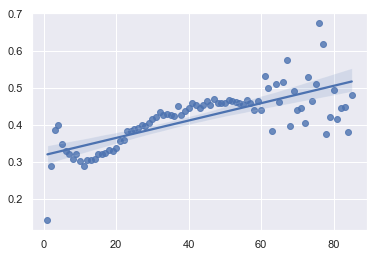

In [39]:
# 山崎氏のnotebookより②
# 文字数とstateの平均値との散布図を描画
df_noc = df_temp.loc[:,['name', 'state']]
df_noc['NoC'] = df_noc.name.str.len()   # Number of Characters
z = df_noc.groupby('NoC').state.mean()
sns.regplot(z.index.array, z.values, order=1)  # 直線近似

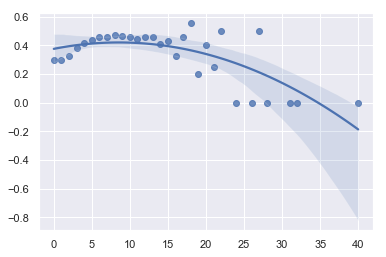

In [40]:
# 山崎氏のnotebookより③
# スペースの数から単語数を推定する手法、スペース数＋１を単語数として、stateの平均値との散布図を描画
df_wor = df_temp.loc[:,['name', 'state']]
df_wor['word'] = df_wor.name.str.count(" ")
z = df_wor.groupby('word').state.mean()
sns.regplot(z.index.array, z.values, order=2)  # ２次関数近似

- ほかにもやり方があるかもしれない？　⇒　たとえばアルファベット順など？

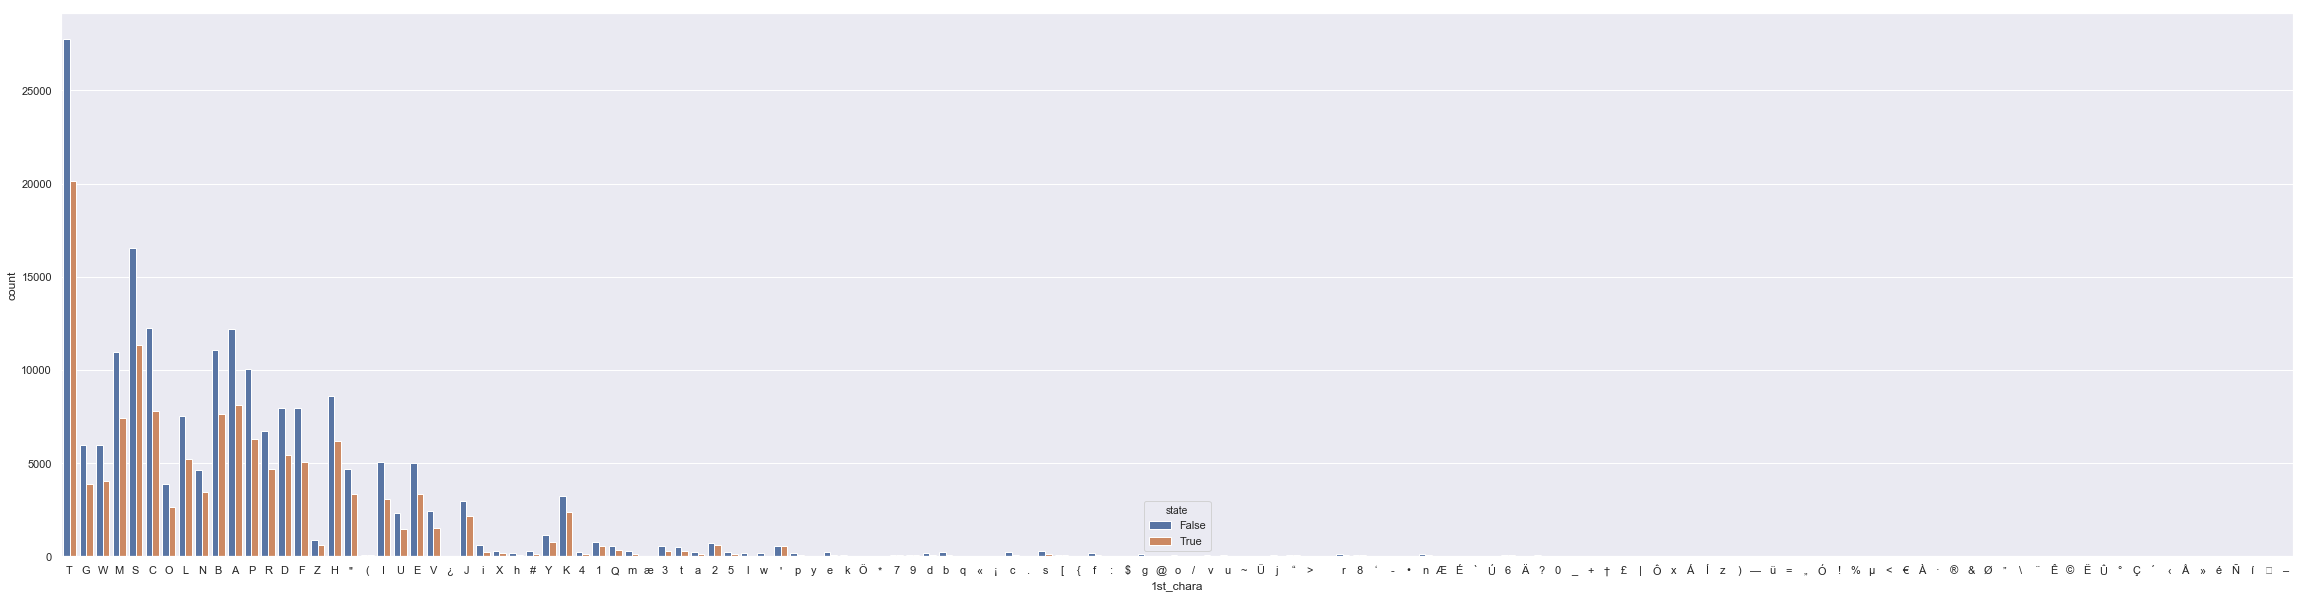

In [41]:
df_1st = df_temp.loc[:,['name', 'state']]

# 先頭の文字のみを切出し
df_1st['1st_chara'] = df_1st.name.str[0]

plt.figure(figsize=(40, 10))

pd.get_dummies(df_1st['1st_chara'])
sns.countplot(x='1st_chara', data = df_1st, hue='state');

- いわゆる特殊文字が予想以上に多く入っている？　何らかの処理方法を考えないと、このままでは使えなさそう。（思いつかない・・・）
- あまり先頭文字は関係ない？
- T が多いのは”The”で始まることが多いから？
#### 　⇒　とりあえずは文字数及び単語数を両方使う方針とする。

### 　３．検証（Validation）の準備　⇒　SVMによる実装・評価
- データの前処理ができたので、検証準備として学習用データとテストデータに分割する
- データ数は十分あると仮定し、ホールドアウト法から検証していく　⇒　余裕があったら交差検証法も試してみること

#### 10/14　追記：SVMを実行するとオーバーフローでPCが強制再起動するため、category列（159列）を含めない形に変更した

In [42]:
# 各種前処理後のデータを統合する　⇒　df_temp2 へ統合していく
df_temp2 = df_temp.drop(columns=['deadline', 'launched'])

# currency の列をTarget Encording 後の数値データに置き換え
df_temp2 = pd.concat([df_temp2.drop(columns='currency'), df_cur.drop(columns=['currency','state'])], axis=1, copy = False)

# country　同上
df_temp2 = pd.concat([df_temp2.drop(columns='country'), df_cou.drop(columns=['country','state'])], axis=1, copy = False)

# name （※文字数と単語数の２列を追加）
df_temp2 = pd.concat([df_temp2.drop(columns='name'), df_noc.drop(columns=['name','state'])], axis=1, copy = False)
df_temp2 = pd.concat([df_temp2, df_wor.drop(columns=['name','state'])], axis=1, copy = False)

# category & main_category　同上
#df_temp2 = pd.concat([df_temp2.drop(columns=['category', 'main_category']), df_CAs.drop(columns='state')], axis=1, copy = False)

# main_categoryのみ統合
df_temp2 = pd.concat([df_temp2.drop(columns=['category', 'main_category']), df_MC.drop(columns=['main_category','state'])], axis=1, copy = False)

display(df_temp2.head())
df_temp2.describe()

,goal,state,usd_goal_real,term,te_currency,te_country,NoC,word,te_MC
0,1000.0,False,1533.95,58,0.409859,0.409690,31.0,5.0,0.347017
1,30000.0,False,30000.00,59,0.418258,0.418193,45.0,7.0,0.417906
2,45000.0,False,45000.00,44,0.418258,0.418193,14.0,2.0,0.417906
3,5000.0,False,5000.00,29,0.418258,0.418193,49.0,6.0,0.526606
5,50000.0,True,50000.00,34,0.418258,0.418193,20.0,2.0,0.275914


,goal,usd_goal_real,term,te_currency,te_country,NoC,word,te_MC
count,3.316750e+05,3.316750e+05,331675.000000,331675.000000,331675.000000,331672.000000,331672.000000,331675.000000
mean,4.425157e+04,4.151000e+04,32.954902,0.403877,0.403877,34.220335,4.654746,0.403877
std,1.117917e+06,1.108930e+06,12.713329,0.038454,0.040034,15.961502,2.784668,0.105920
min,1.000000e-02,1.000000e-02,0.000000,0.269996,0.185310,1.000000,0.000000,0.237856
25%,2.000000e+03,2.000000e+03,29.000000,0.418258,0.418193,21.000000,2.000000,0.341108
50%,5.000000e+03,5.000000e+03,29.000000,0.418258,0.418193,33.000000,4.000000,0.417906
75%,1.500000e+04,1.500000e+04,35.000000,0.418258,0.418193,48.000000,7.000000,0.448890
max,1.000000e+08,1.663614e+08,91.000000,0.452830,0.500000,85.000000,40.000000,0.654352


In [43]:
#欠損値の確認
df_temp2.isnull().sum()

goal             0
state            0
usd_goal_real    0
term             0
te_currency      0
te_country       0
NoC              3
word             3
te_MC            0
dtype: int64

In [44]:
# 欠損値の削除
df_temp3 = df_temp2.dropna()
#df_temp3.describe()

In [46]:
# ホールドアウト法による実装

test_size = 0.9        # 全データのうち、何%をテストデータにするか（学習データを少なくする意図で大きめに設定）

x = df_temp3.drop(columns='state').values #目的変数を除く
y = df_temp3["state"].values #目的変数

X = x.reshape(-1,8) # scikit-learnに入力するために整形

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

print(X_train.size, X_test.size, y_train.size, y_test.size)

265336 2388040 33167 298505


In [47]:
# 標準化
stdsc = StandardScaler()
X_train = stdsc.fit_transform(X_train)
X_test = stdsc.transform(X_test)

print(X_train)

[[-0.01891998 -0.01762151  0.4647352  ...  0.98695329  0.83555426
  -1.19656256]
 [-0.0374859  -0.03806895  2.02603683 ...  1.11216713  0.83555426
   1.16340779]
 [-0.03760194 -0.03819674 -1.48689184 ...  0.54870483 -0.23645343
  -0.52721274]
 ...
 [-0.03690572 -0.03742996 -0.31591562 ...  1.11216713  0.47821837
  -0.58282992]
 [-0.03709911 -0.03691803  0.23053995 ...  0.7365256   0.12088247
   0.12165744]
 [-0.02278788 -0.02188139 -0.31591562 ... -0.26518516 -0.23645343
   0.33780653]]


In [48]:
# SVMの実行①　
C = 5
kernel = "linear"  # ガウスカーネルだと処理が重い？
gamma = 10
clf = SVC(C=C, kernel=kernel, gamma=gamma)
clf.fit(X_train, y_train)

print("識別精度=",clf.score(X_test, y_test))

識別精度= 0.6449908711746872


In [49]:
# SVMの実行②　C = 5 ⇒　20
C = 20
kernel = "linear"  # ガウスカーネルだと処理が重い？
gamma = 10
clf = SVC(C=C, kernel=kernel, gamma=gamma)
clf.fit(X_train, y_train)

print("識別精度=",clf.score(X_test, y_test))

識別精度= 0.6451349223631095


In [51]:
# SVMの実行③　γ = 10 ⇒　20
C = 5
kernel = "linear"  # ガウスカーネルだと処理が重い？
gamma = 20
clf = SVC(C=C, kernel=kernel, gamma=gamma)
clf.fit(X_train, y_train)

print("識別精度=",clf.score(X_test, y_test))

識別精度= 0.6449908711746872


- γの方は少し変えた程度では影響が少ない？

In [52]:
# SVMの実行④　両方あげてみる
C = 20
kernel = "linear"  # ガウスカーネルだと処理が重い？
gamma = 20
clf = SVC(C=C, kernel=kernel, gamma=gamma)
clf.fit(X_train, y_train)

print("識別精度=",clf.score(X_test, y_test))

識別精度= 0.6451349223631095


- もう少し振ってみてもよさそうだが・・・（時間切れ）

### 今回、PCの処理能力の問題で学習用データの数を抑えたのが、精度が悪い根本的な原因と思われる（要検証）
- SVMが実行完了しないため、グリッドサーチを試すことができなかった。グリッドサーチを使えば、少なくとも最適に近いハイパーパラメータを得られたはず
- 交差検証法についても同様だが、データ数が多いことから優先度は低いと考えている
### 次回までにGCP上で実装できるよう、環境構築を行います。（※Category Encorderがインストールできない問題あり）

In [ ]:
# グリッドサーチによる最適なCの探索 ⇒　時間がかかった上にメモリ不足で止まった。一時断念する？
#parameters = {'kernel':['linear', 'rbf'], 'C':[1, 5]} 
#model = SVC(gamma="scale") # gamma=scaleにすると、gammaが自動で計算される
#clf = GridSearchCV(model, parameters, cv=3,)
#clf.fit(X_train, y_train)
#print(clf.best_params_, clf.best_score_)

In [ ]:
# 最適パラメータを用いて識別する
#clf2 = SVC(**clf.best_params_, gamma="scale") # gamma=scaleにすると、gammaが自動で計算される
#clf2.fit(X_train, y_train)
#print("識別精度=",clf2.score(X_test, y_test))

In [ ]:
# 交差検証法による実装　⇒　DAY3前の締め切りに間に合わないので、後日実装を試みます。
